In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
!pip3 install matplotlib pandas seaborn

File 'history.txt' exists. Overwrite? n
Aborting.


In [7]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    sns.set(rc={'figure.figsize':(11.7, 5.27)})
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
    sns.set_theme(style="ticks", palette="pastel")
    

set_style()

In [19]:
def parse_res(file, benchmark="not_provided"):
    try:
        with open(file, 'r') as f:
            lines = f.read().split("\n")
    except:
        print(f"{file} not found")
        return pd.DataFrame()
        
    data = []
    for line in lines[1:]:
        if line:
            try:
                script, time = line.split()
                if float(time) == 0.0:
                    raise Exception()
                sname = script.replace(".sh:", "")
                data.append([f"{sname}_{benchmark}", sname, float(time)])
            except:
                print(f"Skipping {line}")
    
    df = pd.DataFrame(data, columns=["uid", "benchname", "exec_time"])
    df = df.set_index("uid")
    return df

In [36]:
folder = 'original_config'

def average_dfs(dfs):
    df = pd.concat(dfs)
    df = df.groupby('bench_name').mean()
    return df

def get_summary_per_mode(benchmarks, modes):
    # Returns a list of lists where each sublist contains all modes results for a benchmarks
    all_benchs = []
    for benchmark in benchmarks:
        dfs = {}
        for mode in modes:
            df = parse_res(f'{folder}/{benchmark}/{mode}.res', benchmark)
            dfs[mode] = df
        all_benchs.append((benchmark, dfs))
        
    summary_per_mode = {}
    for mode in modes:
        summary = []
        for benchmark, dfs in all_benchs:
            dfs[mode]['benchmark'] = benchmark
            summary.append(dfs[mode])

        new_df = pd.concat(summary, axis = 0)
        new_df['mode'] = mode
        summary_per_mode[mode] = new_df
    return summary_per_mode

def get_speedup_df(summary_per_mode):
    dfs = []
    for mode in summary_per_mode:
        if mode == 'seq':
            continue
        summary_per_mode[mode]['speedup'] = summary_per_mode['seq']['exec_time']/summary_per_mode[mode]['exec_time']
        summary_per_mode[mode].dropna()
        dfs.append(summary_per_mode[mode])
    summary_df = pd.concat(dfs, axis = 0)
    return summary_df




In [34]:
benchmarks = ["oneliners", "unix50", "nlp", "analytics-mts", "dependency_untangling", "max-temp"]
modes = ["distr", "par", "seq"]
summary_per_mode = get_summary_per_mode(benchmarks, modes)
summary_df = pd.concat(summary_per_mode, axis = 1)

# summary_df.to_csv("benchmarks.csv")  
def print_stats(df, baseline_mode, mode):
    speedup_df = pd.DataFrame()
    speedup_df['speedup'] = df[baseline_mode]['exec_time']/df[mode]['exec_time']
    speedup_df.dropna()
    print (f"{mode} speedup over {baseline_mode} stats:\n Mean {speedup_df['speedup'].mean()}, Max {speedup_df['speedup'].max()}, Min  {speedup_df['speedup'].min()}")
    
print_stats(summary_per_mode, "seq", "par")
# print_stats(summary_per_mode, "seq", "hadoopstreaming")
print_stats(summary_per_mode, "seq", "distr")

par speedup over seq stats:
 Mean 2.610473356248885, Max 7.780393703159099, Min  0.5319351763584366
distr speedup over seq stats:
 Mean 16.833980325332522, Max 159.78995222684543, Min  0.7480608319405858


Skipping diff.sh:             0.000
Skipping bigrams.sh:          0.000
Skipping set-diff.sh:         0.000
Skipping 3.sh:                0.000
Skipping 20.sh:               0.000
Skipping 21.sh:               0.000
Skipping 22.sh:               0.000
Skipping 23.sh:               0.000
Skipping 27.sh:               0.000
Skipping 34.sh:               0.000
original_config/nlp/hadoopstreaming.res not found
original_config/analytics-mts/hadoopstreaming.res not found


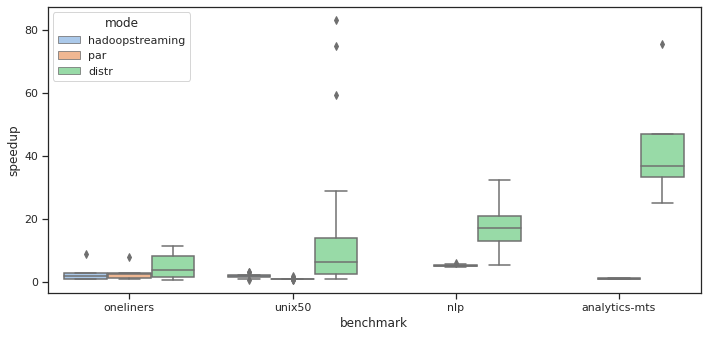

In [38]:
def boxplot(df, x, y, savefig=None):
    sns.boxplot(data=df, x = x, y = y, hue="mode")
        
    if savefig:
        plt.savefig(savefig)
        
benchmarks = ["oneliners", "unix50", "nlp", "analytics-mts"]
modes = ["seq", 'hadoopstreaming', "par", "distr"]
summary_per_mode = get_summary_per_mode(benchmarks, modes)
df = get_speedup_df(summary_per_mode)
boxplot(df, x='benchmark', y='speedup', savefig="distr_boxplot.pdf")

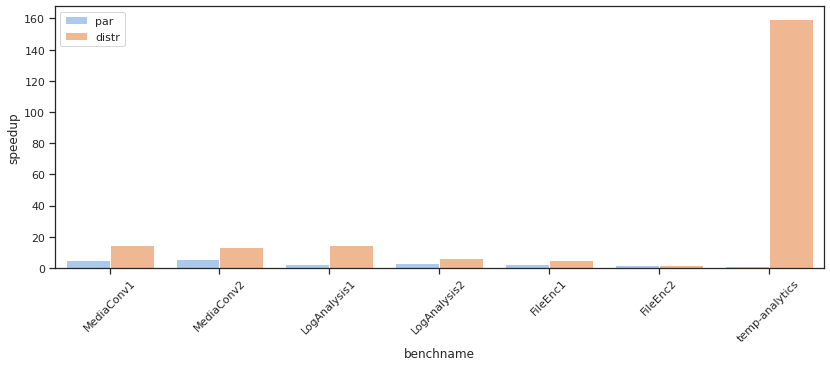

In [39]:
def speedup_barplot(df, x, y, savefig=None):
    sns.barplot(data=df, x=x, y = y, hue="mode")
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
        
benchmarks = ["dependency_untangling", "max-temp"]
modes = ["seq", "par", "distr"]
summary_per_mode = get_summary_per_mode(benchmarks, modes)
df = get_speedup_df(summary_per_mode)
speedup_barplot(df, 'benchname', 'speedup', "par_vs_distr_barplot.pdf")